# Прогнозирование оттока клиентов банка

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

##### Описание данных

Признаки
-	RowNumber — индекс строки в данных
-	CustomerId — уникальный идентификатор клиента
-	Surname — фамилия
-	CreditScore — кредитный рейтинг
-	Geography — страна проживания
-	Gender — пол
-	Age — возраст
-	Tenure — сколько лет человек является клиентом банка
-	Balance — баланс на счёте
-	NumOfProducts — количество продуктов банка, используемых клиентом
-	HasCrCard — наличие кредитной карты
-	IsActiveMember — активность клиента
-	EstimatedSalary — предполагаемая зарплата

Целевой признак
-	Exited — факт ухода клиента

## 1. Подготовка данных

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, plot_confusion_matrix
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle
from random import randrange
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
# data = pd.read_csv('/Users/Mikalai/Documents/Data Science/Проект Отток клиентов/Churn.csv')

In [3]:
display(data.info())
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data.duplicated().sum()

0

Столбцы RowNumber, CustomerId и Surname не несут в себе информации, необходимой для дальнейшей классификации. Их можно удалить.

In [5]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
display(data.head())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Названия столбцов необходимо привести в соответствие с хорошим стилем.

In [6]:
data = data.rename({'CreditScore':'credit_score',
                    'NumOfProducts':'num_of_products',
                    'HasCrCard':'has_cr_card',
                    'IsActiveMember':'is_active_member',
                    'EstimatedSalary':'estimated_salary'}, axis=1)
data.columns = data.columns.str.lower()
display(data.info())
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            9091 non-null   float64
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


None

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Имеются пропуски в столбце tenure — сколько лет человек является клиентом банка.

In [7]:
print(f'Пропущено значений в столбце tenure = {(len(data) - data.tenure.count())/len(data):,.2%}')

Пропущено значений в столбце tenure = 9.09%


Пропущенных значений достаточно много 9.09%. Для заполнения пропусков посмотрим на количество уникальных значений в столбце tenure и распределение значений в столбце tenure по целевому признаку exited.

In [8]:
data['tenure'].value_counts().sort_values()

0.0     382
10.0    446
6.0     881
9.0     882
4.0     885
7.0     925
5.0     927
3.0     928
8.0     933
2.0     950
1.0     952
Name: tenure, dtype: int64

In [9]:
data.loc[data['tenure'].isna(), 'exited'].value_counts()

0    726
1    183
Name: exited, dtype: int64

Заполним пропуски значениями от 1 до 10, чтобы распределение не так сильно изменилось

In [10]:
data.loc[data['tenure'].isna(), 'tenure'] = data.loc[data['tenure'].isna(), 'tenure'].apply(lambda x: randrange(11))

In [11]:
display(data.info())      

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  float64
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


None

In [12]:
data['tenure'].value_counts().sort_values()  

0.0      467
10.0     533
4.0      961
6.0      961
9.0      961
8.0     1004
7.0     1004
5.0     1014
2.0     1026
1.0     1030
3.0     1039
Name: tenure, dtype: int64

Поменяем тип данных в столбце tenure на целочисленный

In [13]:
data['tenure'] = data['tenure'].astype('int64')
display(data.info())
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


None

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Преобразуем категориальные признаки в количественные с помощью техники прямого кодирования (OHE)

In [14]:
data = pd.get_dummies(data=data, columns=['geography', 'gender'], drop_first=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   tenure             10000 non-null  int64  
 3   balance            10000 non-null  float64
 4   num_of_products    10000 non-null  int64  
 5   has_cr_card        10000 non-null  int64  
 6   is_active_member   10000 non-null  int64  
 7   estimated_salary   10000 non-null  float64
 8   exited             10000 non-null  int64  
 9   geography_Germany  10000 non-null  uint8  
 10  geography_Spain    10000 non-null  uint8  
 11  gender_Male        10000 non-null  uint8  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


In [15]:
data.columns = data.columns.str.lower()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   tenure             10000 non-null  int64  
 3   balance            10000 non-null  float64
 4   num_of_products    10000 non-null  int64  
 5   has_cr_card        10000 non-null  int64  
 6   is_active_member   10000 non-null  int64  
 7   estimated_salary   10000 non-null  float64
 8   exited             10000 non-null  int64  
 9   geography_germany  10000 non-null  uint8  
 10  geography_spain    10000 non-null  uint8  
 11  gender_male        10000 non-null  uint8  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


In [16]:
display(data.head())

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_germany,geography_spain,gender_male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


Корреляция данных полученных после OHE-преобразования

Text(0.5, 1.0, 'Корреляция между признаками')

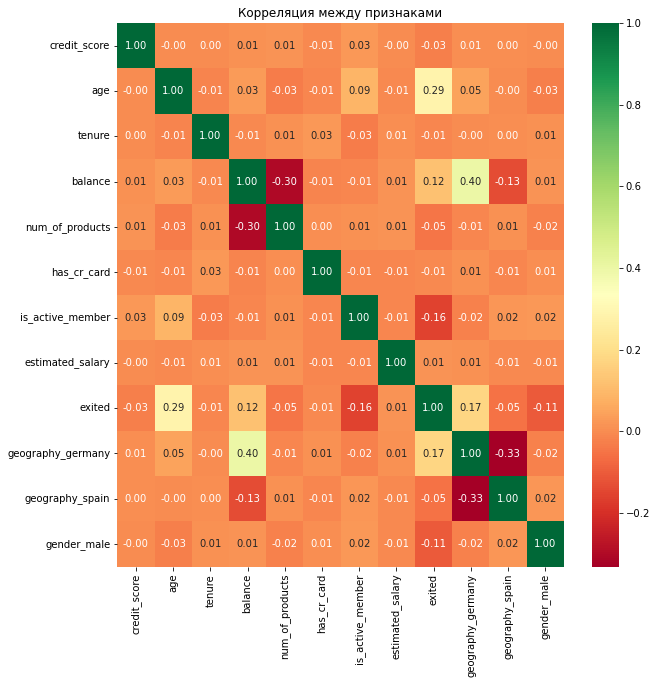

In [17]:
Corr=data.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(Corr, annot=True, fmt='.2f', cmap='RdYlGn')
plt.title('Корреляция между признаками')

Имеется незначительная положительная корреляция целевого признака exited с такими признаками как age, balance, geography_germany, gender_female.

Разделим обучающий датафрейм на features и target - целевой признак

In [18]:
target = data['exited']
features = data.drop('exited', axis=1)

In [19]:
# numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

#scaler = StandardScaler()
#scaler.fit(features[numeric])
#features[numeric] = scaler.transform(data[numeric])
#features.head()

Разделим датасет на обучающую, валидационную и тестовую выборку в пропорции 3:1:1. 

In [20]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            train_size=0.6,
                                                                            random_state=2022)
features_test, features_valid, target_test, target_valid = train_test_split(features_test,
                                                                            target_test,
                                                                            test_size=0.5,
                                                                            random_state=2022)

print('Размер обучающей выборки:',features_train.shape[0])
print('Размер валидационной выборки:',features_valid.shape[0])
print('Размер тестовой выборки:',features_test.shape[0])
print('Общий размер исходного датасета: {} (сумма выборок: {})'.
      format(data.shape[0], features_train.shape[0]+features_valid.shape[0]+features_test.shape[0]))

Размер обучающей выборки: 6000
Размер валидационной выборки: 2000
Размер тестовой выборки: 2000
Общий размер исходного датасета: 10000 (сумма выборок: 10000)


Отмасштабируем количественные признаки.

In [21]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

#### Выводы

Данные успешно загружены и проверены на соответствие описанию. Дубликатов нет.

Столбцы RowNumber, CustomerId и Surname удали, т.к. не несут в себе информации, необходимой для дальнейшей классификации.

Названия столбцов привели в соответствие с хорошим стилем.

Имеются много пропуски в столбце tenure (сколько лет человек является клиентом банка) 9.09%. Заполнили пропуски всеми значениями столбца tenure от 1 до 10, чтобы распределение не так сильно изменилось.

Поменяли тип данных в столбце tenure на целочисленный.

Преобразовали категориальные признаки в количественные с помощью техники прямого кодирования (OHE).

Определили, что имеется незначительная положительная корреляция целевого признака exited с такими признаками как age, balance, geography_germany, gender_female.

Разделили обучающий датафрейм на features и target - целевой признак.

Провели масштабирование количественных признаков, чтобы алгоритм обучения не делал выводов о том, что тот или иной признак важнее только из-за того, что он измеряется в больших числах.

Разделили данные на обучающую + валидационную и тестовую выборки. 

## 2. Исследование задачи

Исследуем баланс классов целевого признака

In [22]:
data['exited'].value_counts()

0    7963
1    2037
Name: exited, dtype: int64

0    0.7963
1    0.2037
Name: exited, dtype: float64


<AxesSubplot:>

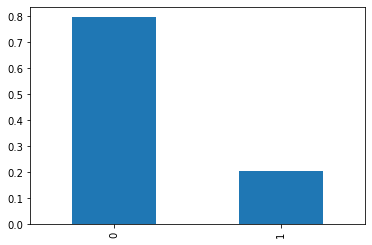

In [23]:
class_frequency = target.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Целевой признак распределён в сооотношении 4:1. 80% клиентов в датафрейме из банка не уходят - в классах дисбаланс. Идеальным балансом чтобы строить модели можно было бы назвать распределение 50/50. Попробуем обучить модель, несмотря на дисбаланс.

Обучение модели без учёта дисбаланса классов

Используем логистическую регрессию

In [24]:
clf = LogisticRegression()

parameters = {'penalty':['l1','l2'],
              'C':np.arange(0.01,1.0,0.1),
              'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'random_state':[2022]}

grid = GridSearchCV(clf, parameters, scoring='f1', verbose=10, n_jobs=-1)
grid.fit(features_train, target_train)
best_params_log_regress = grid.best_params_
print(f'Лучшие параметры: {best_params_log_regress}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Лучшие параметры: {'C': 0.51, 'penalty': 'l1', 'random_state': 2022, 'solver': 'liblinear'}


In [25]:
logistic_model = LogisticRegression(penalty=best_params_log_regress.get('penalty'),
                                    C=best_params_log_regress.get('C'),
                                    solver=best_params_log_regress.get('solver'),
                                    random_state=best_params_log_regress.get('random_state'))

logistic_model.fit(features_train, target_train)

predicted_valid = logistic_model.predict(features_valid)
print(f'Метрика F1 логистической регрессии: {f1_score(target_valid, predicted_valid)}')

Метрика F1 логистической регрессии: 0.3096085409252669


In [26]:
probabilities_valid = logistic_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print(f'Метрика AUC_ROC логистической регрессии: {roc_auc_score(target_valid, probabilities_one_valid)}')

Метрика AUC_ROC логистической регрессии: 0.7615047712703962


Используем случайный лес

In [27]:
clf = RandomForestClassifier()

parameters = {'n_estimators':range(2,101,2),
              'random_state':[2022]}

grid = GridSearchCV(clf, parameters, scoring='f1', cv = 3, verbose=1, n_jobs=-1)
grid.fit(features_train, target_train)
best_params_rand_forest = grid.best_params_
print(f'Лучшие параметры: {best_params_rand_forest}')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Лучшие параметры: {'n_estimators': 82, 'random_state': 2022}


In [28]:
forest_model = RandomForestClassifier(n_estimators=best_params_rand_forest.get('n_estimators'),
                                      random_state=best_params_rand_forest.get('random_state'))

forest_model.fit(features_train, target_train)
predicted_valid = forest_model.predict(features_valid)
print(f'Метрика F1 случайного леса: {f1_score(target_valid, predicted_valid)}')

Метрика F1 случайного леса: 0.5814977973568282


In [29]:
probabilities_valid = forest_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print(f'Метрика AUC_ROC случайного леса: {roc_auc_score(target_valid, probabilities_one_valid)}')

Метрика AUC_ROC случайного леса: 0.8458070792055167


Используем дерево решений

In [30]:
clf = DecisionTreeClassifier()

parameters = {'max_depth':range(1,200,1),
              'criterion':['gini','entropy'],
              'random_state':[2022]}

grid = GridSearchCV(clf, parameters, scoring='f1', verbose=10, n_jobs=-1)
grid.fit(features_train, target_train)
best_params_dec_tree = grid.best_params_
print(f'Лучшие параметры: {best_params_dec_tree}')

Fitting 5 folds for each of 398 candidates, totalling 1990 fits
Лучшие параметры: {'criterion': 'entropy', 'max_depth': 8, 'random_state': 2022}


In [31]:
tree_model = DecisionTreeClassifier(criterion=best_params_dec_tree.get('criterion'),
                                    max_depth=best_params_dec_tree.get('max_depth'),
                                    random_state=best_params_dec_tree.get('random_state'))

tree_model.fit(features_train, target_train)
predicted_valid = tree_model.predict(features_valid)
print(f'Метрика F1 дерева решений: {f1_score(target_valid, predicted_valid)}')

Метрика F1 дерева решений: 0.5834502103786817


In [32]:
probabilities_valid = tree_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print(f'Метрика AUC_ROC дерева решений: {roc_auc_score(target_valid, probabilities_one_valid)}')

Метрика AUC_ROC дерева решений: 0.8250056150446775


#### Вывод

Выявили дисбаланс классов целевого признака как 4:1.

С помощью моделей логической регрессии, случайного леса и дерева решений получили значения метрики F1-меры 0.309, 0.581 и 0.583 соответственно. Значения метрики F1-меры ниже заданного в проекте значения F1>=0.59 на всех моделях.

Для улучшения метрики моделей учтем дисбаланс классов.

## 3. Борьба с дисбалансом

##### 3.1 Борьба с дисбалансом - аргумент class_weight='balanced'  

Используем логистическую регрессию

In [33]:
clf = LogisticRegression()

parameters = {'penalty':['l1','l2'],
              'C':np.arange(0.01,1.0,0.1),
              'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'random_state':[2022]}

grid = GridSearchCV(clf, parameters, scoring='f1', verbose=10, n_jobs=-1)
grid.fit(features_train, target_train)
best_params_log_regress = grid.best_params_
print(f'Лучшие параметры: {best_params_log_regress}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Лучшие параметры: {'C': 0.51, 'penalty': 'l1', 'random_state': 2022, 'solver': 'liblinear'}


In [34]:
model = LogisticRegression(penalty=best_params_log_regress.get('penalty'),
                           C=best_params_log_regress.get('C'),
                           random_state=best_params_log_regress.get('random_state'),
                           solver=best_params_log_regress.get('solver'),
                           class_weight='balanced')
model.fit(features_train, target_train)

LogisticRegression(C=0.51, class_weight='balanced', penalty='l1',
                   random_state=2022, solver='liblinear')

In [35]:
predicted_valid = model.predict(features_valid)
print(f'Метрика F1 логистической регрессии: {f1_score(target_valid, predicted_valid)}')

Метрика F1 логистической регрессии: 0.5012615643397813


In [36]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print(f'Метрика AUC_ROC логистической регрессии: {roc_auc_score(target_valid, probabilities_one_valid)}')

Метрика AUC_ROC логистической регрессии: 0.7661242837024087


Используем случайный лес

In [37]:
clf = RandomForestClassifier()

parameters = {'n_estimators':range(2,101,2),
              'random_state':[2022]}

grid = GridSearchCV(clf, parameters, scoring='f1', cv = 3, verbose=1, n_jobs=-1)
grid.fit(features_train, target_train)
best_params_rand_forest = grid.best_params_
print(f'Лучшие параметры: {best_params_rand_forest}')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Лучшие параметры: {'n_estimators': 82, 'random_state': 2022}


In [38]:
model = RandomForestClassifier(n_estimators=best_params_rand_forest.get('n_estimators'),
                                      random_state=best_params_rand_forest.get('random_state'),
                                      class_weight='balanced')
forest_model.fit(features_train, target_train)

RandomForestClassifier(n_estimators=82, random_state=2022)

In [39]:
predicted_valid = forest_model.predict(features_valid)
print(f'Метрика F1 случайного леса: {f1_score(target_valid, predicted_valid)}')

Метрика F1 случайного леса: 0.5814977973568282


In [40]:
probabilities_valid = forest_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print(f'Метрика AUC_ROC случайного леса: {roc_auc_score(target_valid, probabilities_one_valid)}')

Метрика AUC_ROC случайного леса: 0.8458070792055167


Используем дерево решений

In [41]:
clf = DecisionTreeClassifier()

parameters = {'max_depth':range(1,200,1),
              'criterion':['gini','entropy'],
              'random_state':[2022]}

grid = GridSearchCV(clf, parameters, scoring='f1', verbose=10, n_jobs=-1)
grid.fit(features_train, target_train)
best_params_dec_tree = grid.best_params_
print(f'Лучшие параметры: {best_params_dec_tree}')

Fitting 5 folds for each of 398 candidates, totalling 1990 fits
Лучшие параметры: {'criterion': 'entropy', 'max_depth': 8, 'random_state': 2022}


In [42]:
model = DecisionTreeClassifier(criterion=best_params_dec_tree.get('criterion'),
                               max_depth=best_params_dec_tree.get('max_depth'),
                               random_state=best_params_dec_tree.get('random_state'),
                               class_weight='balanced')
model.fit(features_train, target_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=8, random_state=2022)

In [43]:
predicted_valid = model.predict(features_valid)
print(f'Метрика F1 дерева решений: {f1_score(target_valid, predicted_valid)}')

Метрика F1 дерева решений: 0.5533039647577093


In [44]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print(f'Метрика AUC_ROC дерева решений: {roc_auc_score(target_valid, probabilities_one_valid)}')

Метрика AUC_ROC дерева решений: 0.816411561528749


##### 3.2 Борьба с дисбалансом - увеличение выборки

Функция увеличения выборки


In [45]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=2022)

    return features_upsampled, target_upsampled

<AxesSubplot:xlabel='exited', ylabel='Count'>

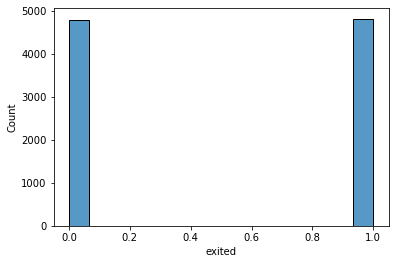

In [46]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
sns.histplot(target_upsampled)

Используем логистическую регрессию

In [47]:
clf = LogisticRegression()

parameters = {'penalty':['l1','l2'],
              'C':np.arange(0.01,1.0,0.1),
              'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'random_state':[2022]}

grid = GridSearchCV(clf, parameters, scoring='f1', verbose=10, n_jobs=-1)
grid.fit(features_upsampled, target_upsampled)
best_params_log_regress = grid.best_params_
print(f'Лучшие параметры: {best_params_log_regress}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Лучшие параметры: {'C': 0.01, 'penalty': 'l1', 'random_state': 2022, 'solver': 'saga'}


In [48]:
logistic_model = LogisticRegression(penalty=best_params_log_regress.get('penalty'),
                                    C=best_params_log_regress.get('C'),
                                    solver=best_params_log_regress.get('solver'),
                                    random_state=best_params_log_regress.get('random_state'))
logistic_model.fit(features_upsampled, target_upsampled)

LogisticRegression(C=0.01, penalty='l1', random_state=2022, solver='saga')

In [49]:
predicted_valid = logistic_model.predict(features_valid)
print(f'Метрика F1 логистической регрессии: {f1_score(target_valid, predicted_valid)}')

Метрика F1 логистической регрессии: 0.5076923076923078


In [50]:
probabilities_valid = logistic_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print(f'Метрика AUC_ROC логистической регрессии: {roc_auc_score(target_valid, probabilities_one_valid)}')

Метрика AUC_ROC логистической регрессии: 0.7701064126845376


Используем случайный лес

In [51]:
clf = RandomForestClassifier()

parameters = {'n_estimators':range(2,101,2),
              'random_state':[2022]}

grid = GridSearchCV(clf, parameters, scoring='f1', cv = 3, verbose=1, n_jobs=-1)
grid.fit(features_upsampled, target_upsampled)
best_params_rand_forest = grid.best_params_
print(f'Лучшие параметры: {best_params_rand_forest}')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Лучшие параметры: {'n_estimators': 62, 'random_state': 2022}


In [52]:
forest_model = RandomForestClassifier(n_estimators=best_params_rand_forest.get('n_estimators'),
                                      random_state=best_params_rand_forest.get('random_state'))
forest_model.fit(features_upsampled, target_upsampled)

RandomForestClassifier(n_estimators=62, random_state=2022)

In [53]:
predicted_valid = forest_model.predict(features_valid)
print(f'Метрика F1 случайного леса: {f1_score(target_valid, predicted_valid)}')

Метрика F1 случайного леса: 0.619235836627141


In [54]:
probabilities_valid = tree_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print(f'Метрика AUC_ROC случайного леса: {roc_auc_score(target_valid, probabilities_one_valid)}')

Метрика AUC_ROC случайного леса: 0.8250056150446775


Используем дерево решений

In [55]:
clf = DecisionTreeClassifier()

parameters = {'max_depth':range(1,200,1),
              'criterion':['gini','entropy'],
              'random_state':[2022]}

grid = GridSearchCV(clf, parameters, scoring='f1', verbose=10, n_jobs=-1)
grid.fit(features_upsampled, target_upsampled)
best_params_dec_tree = grid.best_params_
print(f'Лучшие параметры: {best_params_dec_tree}')

Fitting 5 folds for each of 398 candidates, totalling 1990 fits
Лучшие параметры: {'criterion': 'entropy', 'max_depth': 28, 'random_state': 2022}


In [56]:
tree_model = DecisionTreeClassifier(criterion=best_params_dec_tree.get('criterion'),
                                    max_depth=best_params_dec_tree.get('max_depth'),
                                    random_state=best_params_dec_tree.get('random_state'))
tree_model.fit(features_upsampled, target_upsampled)

DecisionTreeClassifier(criterion='entropy', max_depth=28, random_state=2022)

In [57]:
predicted_valid = tree_model.predict(features_valid)
print(f'Метрика F1 дерева решений: {f1_score(target_valid, predicted_valid)}')

Метрика F1 дерева решений: 0.5288461538461539


In [58]:
probabilities_valid = tree_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print(f'Метрика AUC_ROC дерева решений: {roc_auc_score(target_valid, probabilities_one_valid)}')

Метрика AUC_ROC дерева решений: 0.7025543900543901


##### 3.3 Борьба с дисбалансом - уменьшение выборки

Функция уменьшения выборки

In [59]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=2020)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=2020)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=2022)

    return features_downsampled, target_downsampled

<AxesSubplot:xlabel='exited', ylabel='Count'>

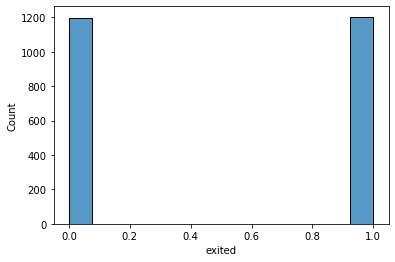

In [60]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)
sns.histplot(target_downsampled)

Используем логистическую регрессию

In [61]:
clf = LogisticRegression()

parameters = {'penalty':['l1','l2'],
              'C':np.arange(0.01,1.0,0.1),
              'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'random_state':[2022]}

grid = GridSearchCV(clf, parameters, scoring='f1', verbose=10, n_jobs=-1)
grid.fit(features_downsampled, target_downsampled)
best_params_log_regress = grid.best_params_
print(f'Лучшие параметры: {best_params_log_regress}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Лучшие параметры: {'C': 0.41000000000000003, 'penalty': 'l1', 'random_state': 2022, 'solver': 'saga'}


In [62]:
logistic_model = LogisticRegression(penalty=best_params_log_regress.get('penalty'),
                                    C=best_params_log_regress.get('C'),
                                    solver=best_params_log_regress.get('solver'),
                                    random_state=best_params_log_regress.get('random_state'))
logistic_model.fit(features_downsampled, target_downsampled)

LogisticRegression(C=0.41000000000000003, penalty='l1', random_state=2022,
                   solver='saga')

In [63]:
predicted_valid = logistic_model.predict(features_valid)
print(f'Метрика F1 логистической регрессии: {f1_score(target_valid, predicted_valid)}')

Метрика F1 логистической регрессии: 0.5033444816053512


In [64]:
probabilities_valid = logistic_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print(f'Метрика AUC_ROC логистической регрессии: {roc_auc_score(target_valid, probabilities_one_valid)}')

Метрика AUC_ROC логистической регрессии: 0.7669361888111887


Используем случайный лес

In [65]:
clf = RandomForestClassifier()

parameters = {'n_estimators':range(2,101,2),
              'random_state':[2022]}

grid = GridSearchCV(clf, parameters, scoring='f1', cv = 3, verbose=1, n_jobs=-1)
grid.fit(features_downsampled, target_downsampled)
best_params_rand_forest = grid.best_params_
print(f'Лучшие параметры: {best_params_rand_forest}')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Лучшие параметры: {'n_estimators': 88, 'random_state': 2022}


In [66]:
forest_model = RandomForestClassifier(n_estimators=best_params_rand_forest.get('n_estimators'),
                                      random_state=best_params_rand_forest.get('random_state'))
forest_model.fit(features_downsampled, target_downsampled)

RandomForestClassifier(n_estimators=88, random_state=2022)

In [67]:
predicted_valid = forest_model.predict(features_valid)
print(f'Метрика F1 случайного леса: {f1_score(target_valid, predicted_valid)}')

Метрика F1 случайного леса: 0.5737410071942446


In [68]:
probabilities_valid = tree_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print(f'Метрика AUC_ROC случайного леса: {roc_auc_score(target_valid, probabilities_one_valid)}')

Метрика AUC_ROC случайного леса: 0.7025543900543901


Используем дерево решений

In [69]:
clf = DecisionTreeClassifier()

parameters = {'max_depth':range(1,200,1),
              'criterion':['gini','entropy'],
              'random_state':[2022]}

grid = GridSearchCV(clf, parameters, scoring='f1', verbose=10, n_jobs=-1)
grid.fit(features_downsampled, target_downsampled)
best_params_dec_tree = grid.best_params_
print(f'Лучшие параметры: {best_params_dec_tree}')

Fitting 5 folds for each of 398 candidates, totalling 1990 fits
Лучшие параметры: {'criterion': 'entropy', 'max_depth': 6, 'random_state': 2022}


In [70]:
tree_model = DecisionTreeClassifier(criterion=best_params_dec_tree.get('criterion'),
                                    max_depth=best_params_dec_tree.get('max_depth'),
                                    random_state=best_params_dec_tree.get('random_state'))
tree_model.fit(features_downsampled, target_downsampled)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=2022)

In [71]:
predicted_valid = tree_model.predict(features_valid)
print(f'Метрика F1 дерева решений: {f1_score(target_valid, predicted_valid)}')

Метрика F1 дерева решений: 0.5432300163132137


In [72]:
probabilities_valid = tree_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print(f'Метрика AUC_ROC дерева решений: {roc_auc_score(target_valid, probabilities_one_valid)}')

Метрика AUC_ROC дерева решений: 0.8259647253787878


#### Выводы

Применены следующие техники балансировки классов:

- аргумент class_weight='balanced'
    * не удалось достичь значения F1>=0.59 ни для одной модели 
    * высокую чувствительность к данному виду балансировки показала только модель логистическая регрессия
- увеличение выборки(upsampling):
    * удалось достичь значения F1>=0.59 для модели случайный лес
    * значение метрики F1 выросло для всех представленных моделей
- уменьшение выборки(downsampling):
    * не удалось достичь значения F1>=0.59 ни для одной модели
    * для небольших наборов данных использование данной техники нецелесообразно
- значение метрики AUC_ROC оставлось высоким для всех представленных моделей

## 4. Тестирование модели

Объединения учебной и валидационной выборок

(8000, 11)
(8000,)


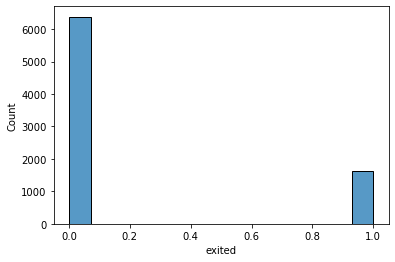

In [73]:
features_test_fit = features_train.append(features_valid)
target_test_fit = target_train.append(target_valid)

sns.histplot(target_test_fit)

print(features_test_fit.shape)
print(target_test_fit.shape)

Проверка константной модели

In [74]:
model = DummyClassifier(random_state=2022)
model.fit(features_test_fit, target_test_fit)

predicted_valid = model.predict(features_test)
probabilities_valid = model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]
print(f'Метрика F1 константной модели: {f1_score(target_test, predicted_valid)}')
print(f'Метрика AUC_ROC константной модели: {roc_auc_score(target_test, probabilities_one_valid)}')

Метрика F1 константной модели: 0.0
Метрика AUC_ROC константной модели: 0.5


Тетирование лучшей модели

In [75]:
features_upsampled, target_upsampled = upsample(features_test_fit, target_test_fit, 4)
forest_model.fit(features_upsampled, target_upsampled)

predicted_test = forest_model.predict(features_test)
probabilities_valid = forest_model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]
print(f'Метрика F1 лучшей модели: {f1_score(target_test, predicted_test)}')
print(f'Метрика AUC_ROC лучшей модели: {roc_auc_score(target_test, probabilities_one_valid)}')

Метрика F1 лучшей модели: 0.6281879194630872
Метрика AUC_ROC лучшей модели: 0.86593845580516


При тестировании лучшей модели случайный лес удалось достичь значения метрики F1>=0.59

Как сильно наша модель отличается от случайной наглядно показывает метрика качества ROC-кривая — AUC-ROC 

In [76]:
def draw_ROC(target_test, features_test, forest_model):
    fpr, tpr, thresholds = roc_curve(target_test, forest_model.predict_proba(features_test)[:,1], pos_label=1)
    plt.figure(figsize=(12, 10))
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.show() 

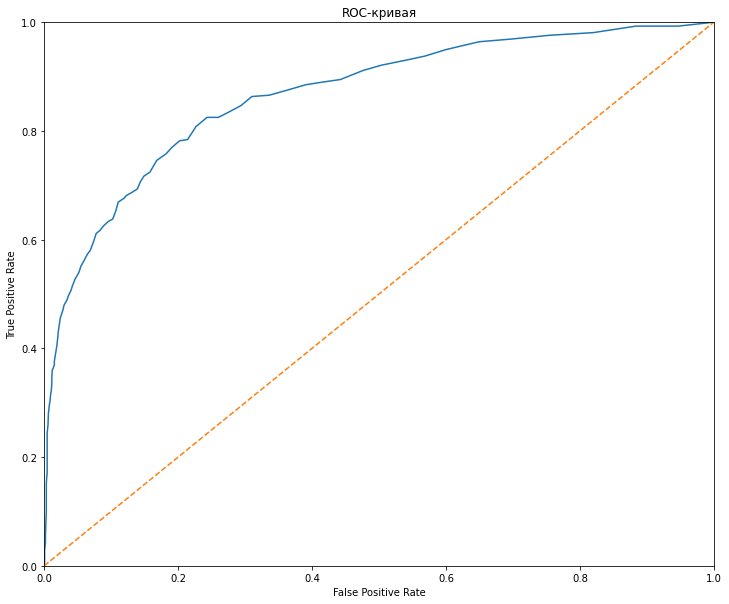

In [77]:
draw_ROC(target_test, features_test, forest_model)

#### Общий вывод

Произвели предобработку данных.

Заполнены пропуски в столбце tenure пропуски всеми значениями столбца tenure от 1 до 10, чтобы распределение не так сильно изменилось.

Преобразовали категориальные признаки в количественные с помощью техники прямого кодирования (OHE).

Разделили обучающий датафрейм на features и target - целевой признак.

Провели масштабирование количественных признаков, чтобы алгоритм обучения не делал выводов о том, что тот или иной признак важнее только из-за того, что он измеряется в больших числах.

Исходные данные разделили на обучающую, валидационную и тестовую выборки в соотношении 3:1:1 соответственно

Выявили дисбаланс классов целевого признака как 4:1.

Проведён анализ моделей логической регрессии, случайного леса и дерева решений без учёта дисбаланса классов. Максимальное значение метрики F1 = 0.58 получено при обучении модели случайного леса и дерева решений. Качество моделей также оценено по метрике AUC_ROC. Максимальное значение метрики AUC_ROC = 0.84 достигнуто при обучении модели случайного леса.

Применены следующие техники балансировки классов:
- аргумент class_weight='balanced'
- увеличение выборки(upsampling)
- уменьшение выборки(downsampling)

Взвешивание классов с помощью параметра class_weight не дало значительного увеличения метрики F1.

Downsampling отрицательного класса не дал необходимый прирост метрики F1 для всех моделей.

Upsampling положительного класса дал необходимое значение F1>=0.59 на валидационной выборке модели случайный лес:
- F1 = 0.619
- AUC_ROC = 0.825

Проведено тестирование лучшей модели случайный лес на тестовой выборке:
- F1 = 0.628
- AUC_ROC = 0.865

При тестировании лучшей лучшей модели случайный лес получили необходимое значение метрики F1>=0.59.